# 2D plotting of LES output
* The below notebook compares selected simulations against observational targets that were collected from satellite and ground-based retrievals.
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [404]:
os.getcwd()


'/data/project/comble-mip/satellite_imagery/viirs'

In [405]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

In [408]:
## select times
Time_Vec = [0.,1.,2.,6.,10.,14.,18.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours
Spat_Window = 100.0 ## km


In [409]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
           

In [410]:
## load satellite imagery

import glob, os
import geopy
import geopy.distance

os.chdir("/data/project/comble-mip/satellite_imagery/viirs/")
counter_dat = 0
for file in glob.glob("*03DNB*.nc"):
    
    ## load geolocation    
    ds_geo = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file)
    
    ## load imagery
    file_sp = file.split('.')    
    file_img = glob.glob(file_sp[0].replace('3','2')+'.'+file_sp[1]+'.'+file_sp[2]+'*')[0]
    ds_img = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file_img)
    
    ## time
    file_time = np.datetime64('2020-01-01') + np.timedelta64(int(file_sp[1][5:8])-1,'D') + np.timedelta64(int(file_sp[2][0:2]),'h')+ np.timedelta64(int(file_sp[2][2:4]),'m')
    
    ## for each requested model timestep, check if image cover right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            ## select pixels within window
            pix_num = ((ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                       (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                       (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                       (ds_geo['geolocation_data/longitude'][:] < LON_MAX)).sum()
            print(pix_num)
            
            if pix_num > 0:
                
                ds_sub = ds_img['observation_data/DNB_observations'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                          (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                          (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                          (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lat = ds_geo['geolocation_data/latitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                  (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                  (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                  (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lon = ds_geo['geolocation_data/longitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                   (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                   (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                   (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                da = xr.DataArray(
                    data = ds_sub,
                    dims = ['pixel'],
                    coords = dict(
                        lon = (['pixel'],ds_lon),
                        lat = (['pixel'],ds_lat)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                for ii in range(len(ds_sub)):
                    da['x_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (da['lat'][ii],Lon_OI)).km * np.sign((da['lon'][ii].data - Lon_OI))
                    da['y_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (Lat_OI,da['lon'][ii])).km * np.sign((da['lat'][ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da[np.abs(da['x_dist']) <= Spat_Window/2]
                da = da[np.abs(da['y_dist']) <= Spat_Window/2]
                
                ## normalize radiance values to resemble LES pseudo-albedo
                da.data = ((da.data - da.data.min())/(da.data.max() - da.data.min()))*0.8
                    
                da['x_dist_round'] = np.round(da['x_dist'])
                da['y_dist_round'] = np.round(da['y_dist'])
                
                for yy in np.unique(da['y_dist_round']):
                    da_sub = da[da['y_dist_round'] == yy]
                    da_stat = da_sub.groupby('x_dist_round').mean() 
                    da_stat['y_dist_round'] = yy 
                    if yy == np.unique(da['y_dist_round'])[0]:
                        da_stat_stack = xr.concat([da_stat],dim='y_dist_round')
                    else:
                        da_stat_stack = xr.concat([da_stat_stack,da_stat],dim='y_dist_round')
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['satellite'] = file_sp[0]+'.'+file_sp[1]+'.'+file_sp[2]
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='satellite')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='satellite')
    counter_dat += 1
    print(file)
    print(file_img)    


2020-03-13T00:00:00
25855
2020-03-13T01:00:00
25659
2020-03-13T02:00:00
25653
2020-03-13T06:00:00
25511
2020-03-13T10:00:00
0
2020-03-13T14:00:00
0
2020-03-13T18:00:00
0
VNP03DNB.A2020073.1306.002.2021125004801.nc
VNP02DNB.A2020073.1306.002.2021126174604.nc
2020-03-13T00:00:00
26080
2020-03-13T01:00:00
26047
2020-03-13T02:00:00
26107
2020-03-13T06:00:00
26105
2020-03-13T10:00:00
26252
2020-03-13T14:00:00
26211
2020-03-13T18:00:00
26395
VJ103DNB.A2020073.1212.002.2020073175644.nc
VJ102DNB.A2020073.1212.002.2020073182754.nc


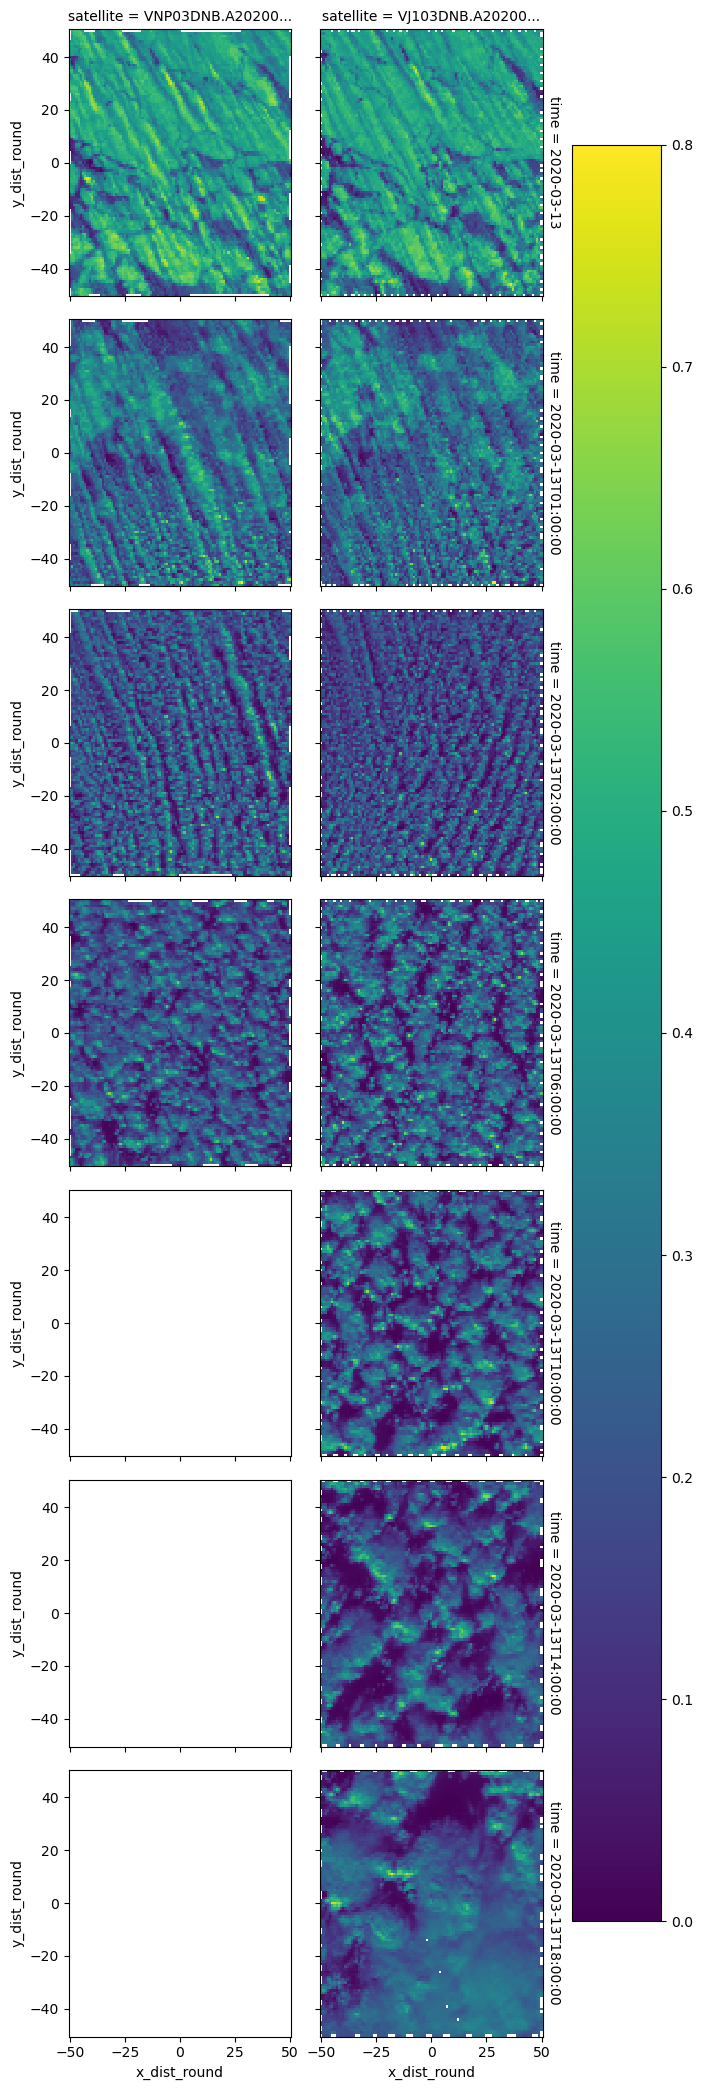

In [411]:
da_stat_ststst.plot(row='time',col='satellite')

In [426]:
[t for t in Time_Vec if t > 0]

[1.0, 2.0, 6.0, 10.0, 14.0, 18.0]

In [427]:
#%run functions_plotting.py 

var_vec_2d = ['alb']

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0])

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


/opt/conda/lib/python3.10/site-packages/xarray/plot/facetgrid.py:187: UserWarning: Ignoring col_wrap since both col and row were passed
  warnings.warn("Ignoring col_wrap since both col and row were passed")


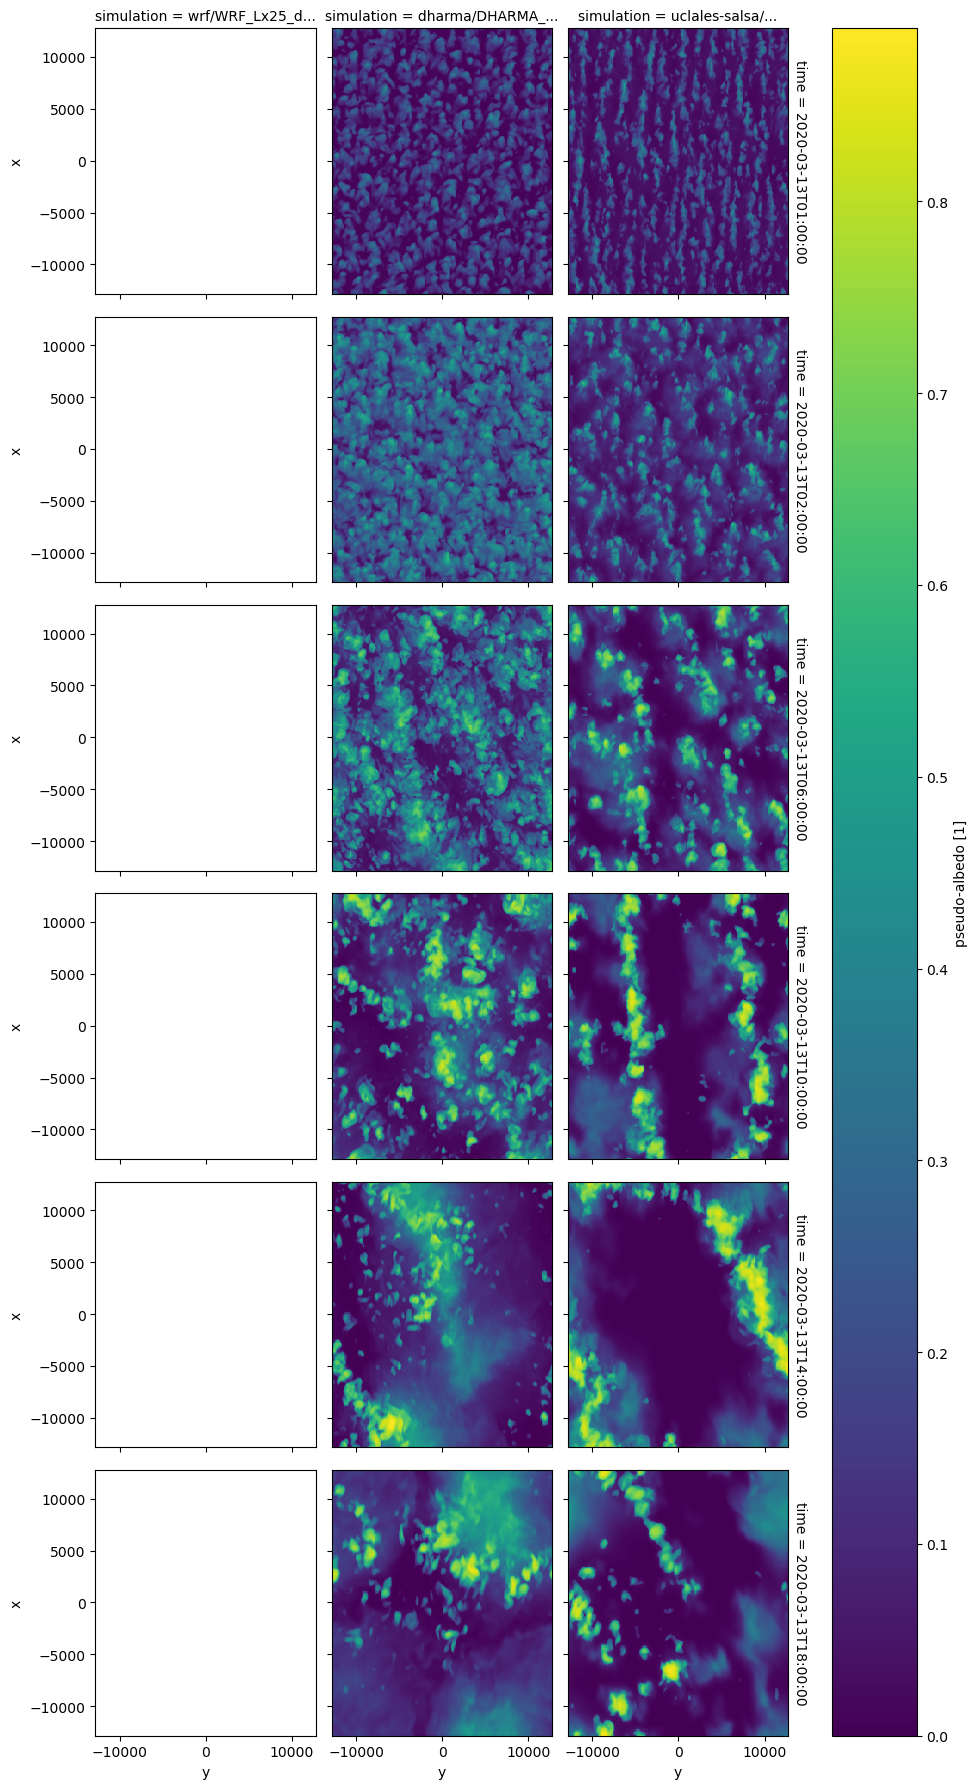

In [428]:
df_col_2d['alb'].plot(row='time',col_wrap=7,col='simulation')